In [1]:
from insert_errors import (
    insert_maxim_error, float_to_maxim, maxim_to_float, insert_maxim_error_perbit
)
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
setpoint = 60
std_noise = .25
num_samples = 1_000_000
# SEU_thresh = .90 # 10% chance of a bit flipping
SEU_perbit = .99 # 1% chance of a bit flipping, for each bit

In [3]:
# UTLIS
def error_stats(data, expected):
    error = data - expected
    rmse = np.sqrt(np.sum((error)**2)/data.shape[0])
    print(f'RMSE from setpoint: {rmse}')
    print(f'Standard Deviation of error: {np.std(error)}')
    print(f'Largest error: {np.max(error)} smallest error: {np.min(error)}')

In [4]:
'''
Experiment 0 a: Collect 1000000 temperatures from one TC with normal noise to
calculate RMSE for a non-upset datastream
'''
clean_data = np.full((num_samples,), setpoint, dtype=np.float32)
noise = np.random.normal(loc=0, scale=std_noise, size=clean_data.shape)
clean_data += noise

for i, d in enumerate(clean_data):
    # Quantize to maxim precision of .25
    clean_data[i] = maxim_to_float(float_to_maxim(d))

RMSE from setpoint: 0.2889750205467594
Standard Deviation of error: 0.2603704035282135
Largest error: 1.0 smallest error: -1.25


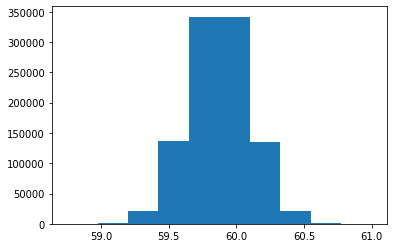

In [5]:
error_stats(clean_data, setpoint)
plt.hist(clean_data)
plt.show()

RMSE from setpoint: 0.15529938010480757
Standard Deviation of error: 0.09210208610977527
Largest error: 0.28125 smallest error: -0.5625


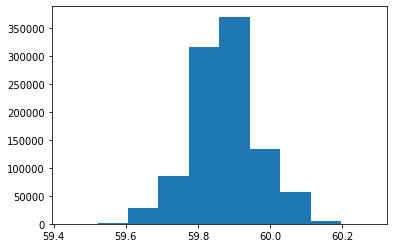

In [7]:
'''
Experiment 0 b: Collect 1000000 temperatures from 8 TCs averaged with normal
noise to calculate RMSE for a non-upset datastream
'''
tcs = np.array([(np.full((num_samples,), setpoint, dtype=np.float32) +
       np.random.normal(loc=0, scale=std_noise, size=(num_samples,)))
       for i in range(8)])

for tc in tcs:
    for i, d in enumerate(tc):
        # Quantize to maxim precision of .25
        tc[i] = maxim_to_float(float_to_maxim(d))

tc_avg = np.mean(tcs, axis=0)
error_stats(tc_avg, setpoint)
plt.hist(tc_avg)
plt.show()

In [9]:
''' 
Experiment 1: Collect 1000000 temperatures from one TC with normal noise
and apply SEUs to each reading with a probability P
'''

tc_data = np.full((num_samples,), setpoint, dtype=np.float32)
noise = np.random.normal(loc=0, scale=std_noise, size=tc_data.shape)
tc_data += noise

for i, d in enumerate(tc_data):
    # Quantize to maxim precision of .25
    tc_data[i] = maxim_to_float(float_to_maxim(d))
    

with_seu = np.zeros_like(tc_data)
for i in range(with_seu.shape[0]):
    with_seu[i] = insert_maxim_error_perbit(tc_data[i],
                                            upset_threshold=SEU_perbit)
    

RMSE from setpoint: 119.5335103475172
Standard Deviation of error: 118.25186920166016
Largest error: 1791.5 smallest error: -1655.5


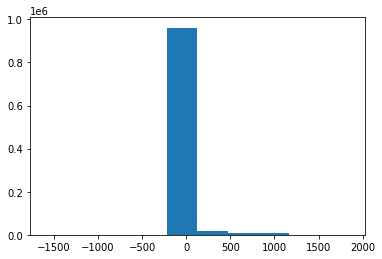

In [10]:
error_stats(with_seu, setpoint)
plt.hist(with_seu)
plt.show()

In [12]:
''' 
Experiment 2 a: Generate temperatures with SEUs for 8 TCs and do the 
average on them.
'''
tcs = np.array([(np.full((num_samples,), setpoint, dtype=np.float32) +
       np.random.normal(loc=0, scale=std_noise, size=tc_data.shape))
       for i in range(8)])

for tc in tcs:
    for i, d in enumerate(tc):
        # Quantize to maxim precision of .25
        tc[i] = maxim_to_float(float_to_maxim(d))

In [14]:
tcs_seu = np.array([np.zeros_like(tcs[0]) for i in range(len(tcs))])

for idx, tc in enumerate(tcs_seu):
    for i in range(tc.shape[0]):
        tc[i] = insert_maxim_error_perbit(tcs[idx][i],
                                          upset_threshold=SEU_perbit)

In [15]:
# Compute avg
tc_avg = np.mean(tcs_seu, axis=0)

RMSE from setpoint: 45.540393655279615
Standard Deviation of error: 42.00520050268957
Largest error: 448.15625 smallest error: -207.25


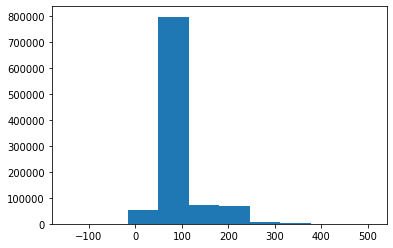

In [16]:
error_stats(tc_avg, setpoint)
plt.hist(tc_avg)
plt.show()

RMSE from setpoint: 1.4467588924795831
Standard Deviation of error: 1.443314018784871
Largest error: 257.0 smallest error: -60.0


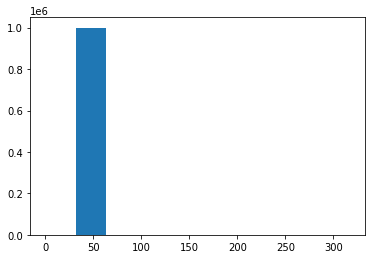

In [17]:
''' 
Experiment 2 b: Median on 8 TCs
'''
tc_medians = np.median(tcs_seu, axis=0)
error_stats(tc_medians, setpoint)
plt.hist(tc_medians)
plt.show()

In [18]:
# Plurality UTILS
from itertools import chain, combinations

def powerset(iterable, k):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(k, len(s)+1))

In [19]:
'''
Experiment 2 c: k-Plurality voting on 8 TCs
k=?
When no agreement, output median.
Use average of agreeing subset
'''

# For each set of measurements, determine biggest subset of agreeable values
# for i in range(tcs_seu.shape[1]):
def plurality(tcs_seu, num_pts, k, delta, suppress=False):
    defaults = np.median(tcs_seu, axis=0)
    voted_out = defaults.copy()

    for i in range(num_pts):
        ps = powerset(tcs_seu[:, i], k)
        best = tuple()
        for s in ps: # for each subset in powerset i.e. (60, 60.5, 71)
            all_within = True
            for meas in s:
                for other in s:
                    # If any measurement in this subset is not valid, break
                    if abs(meas - other) > delta:
                        all_within = False
                        break
                if not all_within:
                    break
            if not all_within:
                continue
            if all_within and len(s) > len(best):
                best = s
        if len(best) >= k:
            voted_avg = sum(best)/len(best)
            voted_out[i] = voted_avg
        else:
            if not suppress:
                print(f'i={i} using median {defaults[i]} for data {tcs_seu[:,i]}') 
    return voted_out

def plurality_fast(tcs_seu, num_pts, k, delta, suppress=False):
    defaults = np.median(tcs_seu, axis=0)
    voted_out = defaults.copy()

    for i in range(num_pts):
        ps = powerset(tcs_seu[:, i], k)
        best = tuple()
        for s in ps: # for each subset in powerset i.e. (60, 60.5, 71)
            if abs(max(s) - min(s)) > delta:
                continue
            if len(s) > len(best):
                best = s
        if len(best) >= k:
            voted_avg = sum(best)/len(best)
            voted_out[i] = voted_avg
        else:
            if not suppress:
                print(f'i={i} using median {defaults[i]} for data {tcs_seu[:,i]}') 
    return voted_out

In [20]:
# With max min optimization
s = time.time()
plural_voted100fast = plurality_fast(tcs_seu, 100, 5, 1)
e = time.time()
print(e - s)

0.19336676597595215


In [21]:
# With max min optimization
s = time.time()
plural_voted1000fast = plurality_fast(tcs_seu, 1000, 5, 1)
e = time.time()
print(e - s)

i=125 using median 61.25 for data [ 59.75  187.5   571.75   59.75   60.25  319.625  60.     62.25 ]
i=164 using median 59.75 for data [  44.    188.     59.75 1083.75   59.75   59.75   59.75  315.75]
i=416 using median 60.25 for data [ 60.25  316.25   63.5    59.75  124.375  59.25   51.5    60.25 ]
i=566 using median 60.0 for data [572.   -60.25  59.75 316.25  60.    59.75  60.   189.  ]
i=607 using median 60.125 for data [ 60.    60.25 124.    60.    52.   124.    60.25  58.75]
i=722 using median 59.4375 for data [ 59.625  52.25   51.75   59.75   30.     59.25  315.75   60.   ]
i=854 using median 61.75 for data [188.    60.    63.5  123.75  60.   124.5   60.    59.75]
i=928 using median 59.875 for data [ 58.5  187.5  571.5  -60.   315.75  59.5   60.25  59.5 ]
0.2829906940460205


In [22]:
# With max min optimization
s = time.time()
plural_voted10_000fast = plurality_fast(tcs_seu, 10000, 5, 1)
e = time.time()
print(e - s)

i=125 using median 61.25 for data [ 59.75  187.5   571.75   59.75   60.25  319.625  60.     62.25 ]
i=164 using median 59.75 for data [  44.    188.     59.75 1083.75   59.75   59.75   59.75  315.75]
i=416 using median 60.25 for data [ 60.25  316.25   63.5    59.75  124.375  59.25   51.5    60.25 ]
i=566 using median 60.0 for data [572.   -60.25  59.75 316.25  60.    59.75  60.   189.  ]
i=607 using median 60.125 for data [ 60.    60.25 124.    60.    52.   124.    60.25  58.75]
i=722 using median 59.4375 for data [ 59.625  52.25   51.75   59.75   30.     59.25  315.75   60.   ]
i=854 using median 61.75 for data [188.    60.    63.5  123.75  60.   124.5   60.    59.75]
i=928 using median 59.875 for data [ 58.5  187.5  571.5  -60.   315.75  59.5   60.25  59.5 ]
i=1023 using median 59.625 for data [ 43.75 123.5   59.25  60.    52.    60.25  59.    60.  ]
i=1107 using median 59.875 for data [  27.75 1083.5    59.75   52.     60.    315.75   60.5    59.75]
i=1213 using median 59.625 for da

In [23]:
# With max min optimization
s = time.time()
plural_voted100_000fast = plurality_fast(tcs_seu, 100000, 5, 1, suppress=True)
e = time.time()
print(e - s)

11.782464504241943


In [24]:
# k=5, delta=1
s = time.time()
plural_voted1_000_000fast = plurality_fast(tcs_seu, 1000000, 5, 1, suppress=True)
e = time.time()
print(e - s)
error_stats(plural_voted1_000_000fast, setpoint)

106.50875926017761
RMSE from setpoint: 1.4448112160046602
Standard Deviation of error: 1.4410664360699346
Largest error: 257.0 smallest error: -60.0


In [25]:
error_stats(plural_voted1_000_000fast, setpoint)

RMSE from setpoint: 1.4448112160046602
Standard Deviation of error: 1.4410664360699346
Largest error: 257.0 smallest error: -60.0


In [29]:
# k=5, delta=1
s = time.time()
plural_k5d1 = plurality_fast(tcs_seu, 1000000, 5, 1, suppress=True)
e = time.time()
print(e - s)
error_stats(plural_k5d1, setpoint)

101.59947419166565
RMSE from setpoint: 1.4448112160046602
Standard Deviation of error: 1.4410664360699346
Largest error: 257.0 smallest error: -60.0


In [26]:
# k=4, delta=1
s = time.time()
plural_k4d1 = plurality_fast(tcs_seu, 1000000, 4, 1, suppress=True)
e = time.time()
print(e - s)
error_stats(plural_k4d1, setpoint)

167.9993965625763
RMSE from setpoint: 0.9508494858886664
Standard Deviation of error: 0.943616624460667
Largest error: 257.0 smallest error: -32.1875


In [30]:
# k=4, delta=2
s = time.time()
plural_k4d2 = plurality_fast(tcs_seu, 1000000, 4, 2, suppress=True)
e = time.time()
print(e - s)
error_stats(plural_k4d2, setpoint)

168.6077024936676
RMSE from setpoint: 0.9466661811906052
Standard Deviation of error: 0.9393654402932222
Largest error: 257.0 smallest error: -32.1875


In [27]:
# k=3, delta=1
s = time.time()
plural_k3d1 = plurality_fast(tcs_seu, 1000000, 3, 1, suppress=True)
e = time.time()
print(e - s)
error_stats(plural_k3d1, setpoint)

218.27114176750183
RMSE from setpoint: 1.8199984404866307
Standard Deviation of error: 1.8161366397438883
Largest error: 1023.75 smallest error: -119.75


In [28]:
# k=2, delta=1
s = time.time()
plural_k2d1 = plurality_fast(tcs_seu, 1000000, 2, 1, suppress=True)
e = time.time()
print(e - s)
error_stats(plural_k2d1, setpoint)

234.32266926765442
RMSE from setpoint: 2.9695637856897474
Standard Deviation of error: 2.967401626439815
Largest error: 1024.375 smallest error: -119.75
